In [1]:
from typing import Dict

import torch

from deepfloyd_if.pipelines import dream
from deepfloyd_if.modules import T5Embedder, IFStageI, IFStageII, StableStageIII
from deepfloyd_if.finetune.textual_inversion import add_vtokens, object_variations

/home/jiaqiguo/miniconda3/envs/deepfloyd/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-06-21 02:46:12,515] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)
FORCE_MEM_EFFICIENT_ATTN= 0 @UNET:QKVATTENTION


In [2]:
DEVICE = "cuda:0"

In [3]:
t5 = T5Embedder(device="cpu", torch_dtype=torch.float32, use_offload_folder=None)
t5.text_preprocessing = lambda x: x

/home/jiaqiguo/miniconda3/envs/deepfloyd/lib/python3.8/site-packages/huggingface_hub/file_download.py:1104: FutureWarning: The `force_filename` parameter is deprecated as a new caching system, which keeps the filenames as they are on the Hub, is now in place.
  warnings.warn(
Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.04s/it]


In [4]:
if_I = IFStageI('IF-I-XL-v1.0', device=DEVICE, model_kwargs={"precision": 32})
if_I.model.to(dtype=if_I.model.dtype)

UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=704, out_features=2816, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=2816, out_features=2816, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 704, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 704, eps=1e-05, affine=True)
          (1): GELU(approximate='none')
          (2): Conv2d(704, 704, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): GELU(approximate='none')
          (1): Linear(in_features=2816, out_features=1408, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 704, eps=1e-05, affine=True)
          (1): GELU(approximate='none')
          (2): Dropout(p

In [5]:
def basic_test(t5, if_I, if_II, prompt: str) -> None:
    init_result = dream(
        t5=t5, if_I=if_I, if_II=if_II,
        prompt=[prompt],
        seed=42,
        if_I_kwargs={
            "guidance_scale": 7.0,
            "sample_timestep_respacing": "smart100",
        },
    )
    if_I.show(init_result['I'], size=16)
    if if_II is not None:
        if_II.show(init_result['II'] , size=16)

def load_ckpt(if_I: IFStageI, ckpt_path: str) -> None:
    state = torch.load(ckpt_path)
    if_I.model = state

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.64it/s]


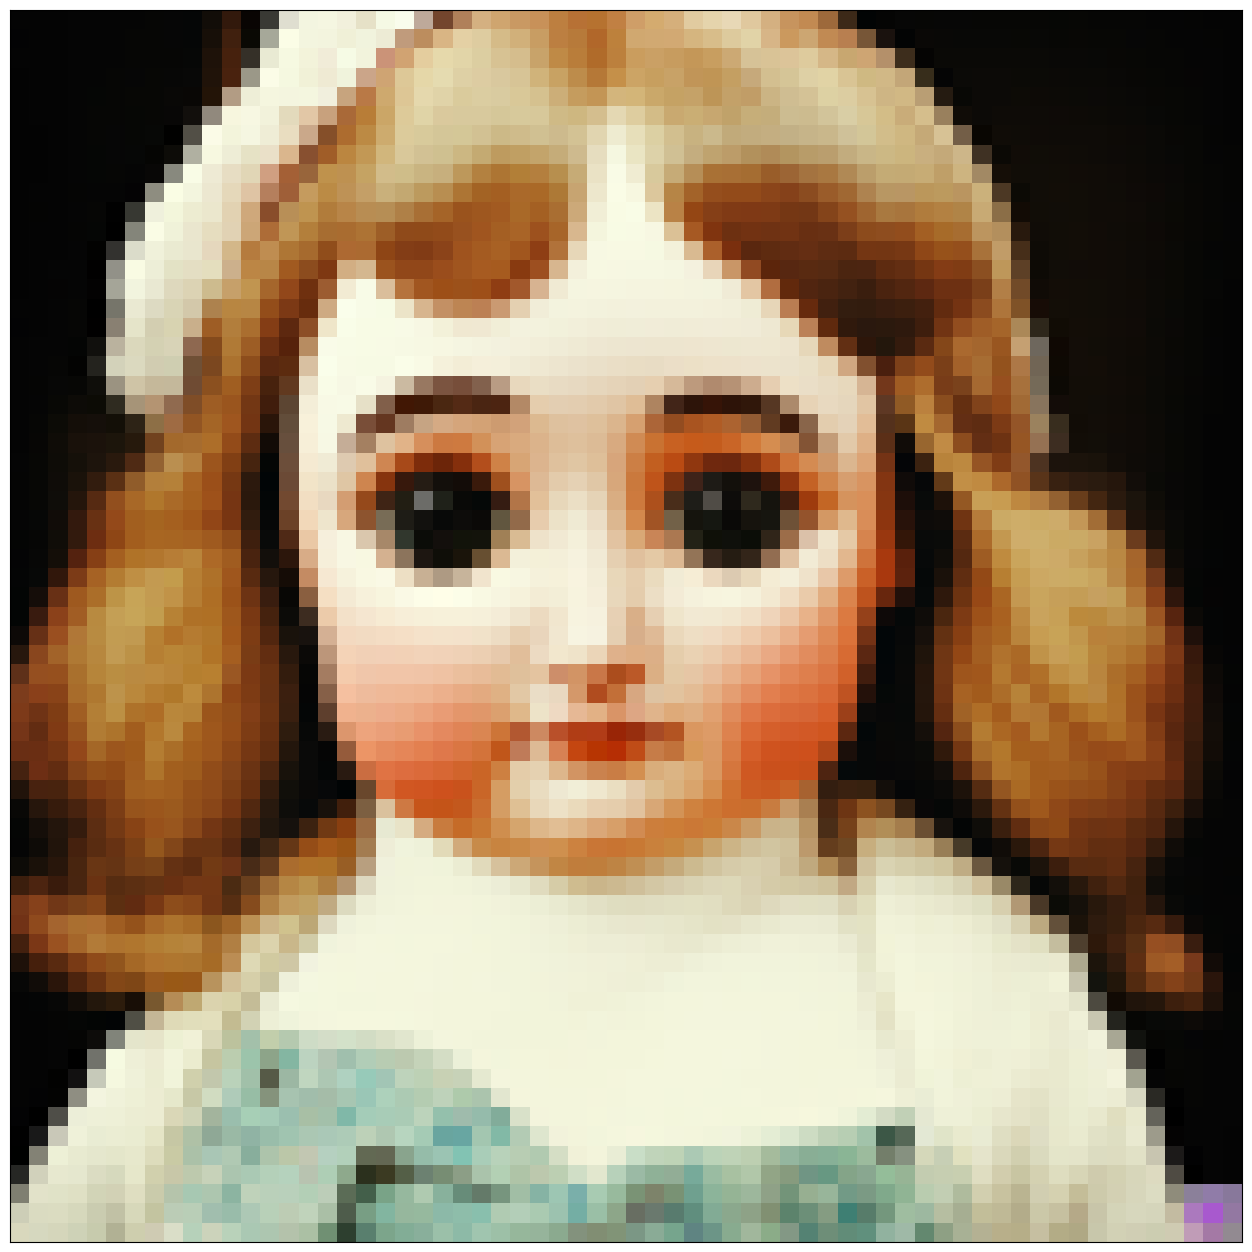

In [6]:
basic_test(t5, if_I, None, "a doll")

In [7]:
CKPT_PATH = "/data/jiaqi/if_ckpts/dreambooth_step400_v_white_background_lr_1e-7/unet-step-1000.bin"
load_ckpt(if_I, CKPT_PATH)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.07it/s]


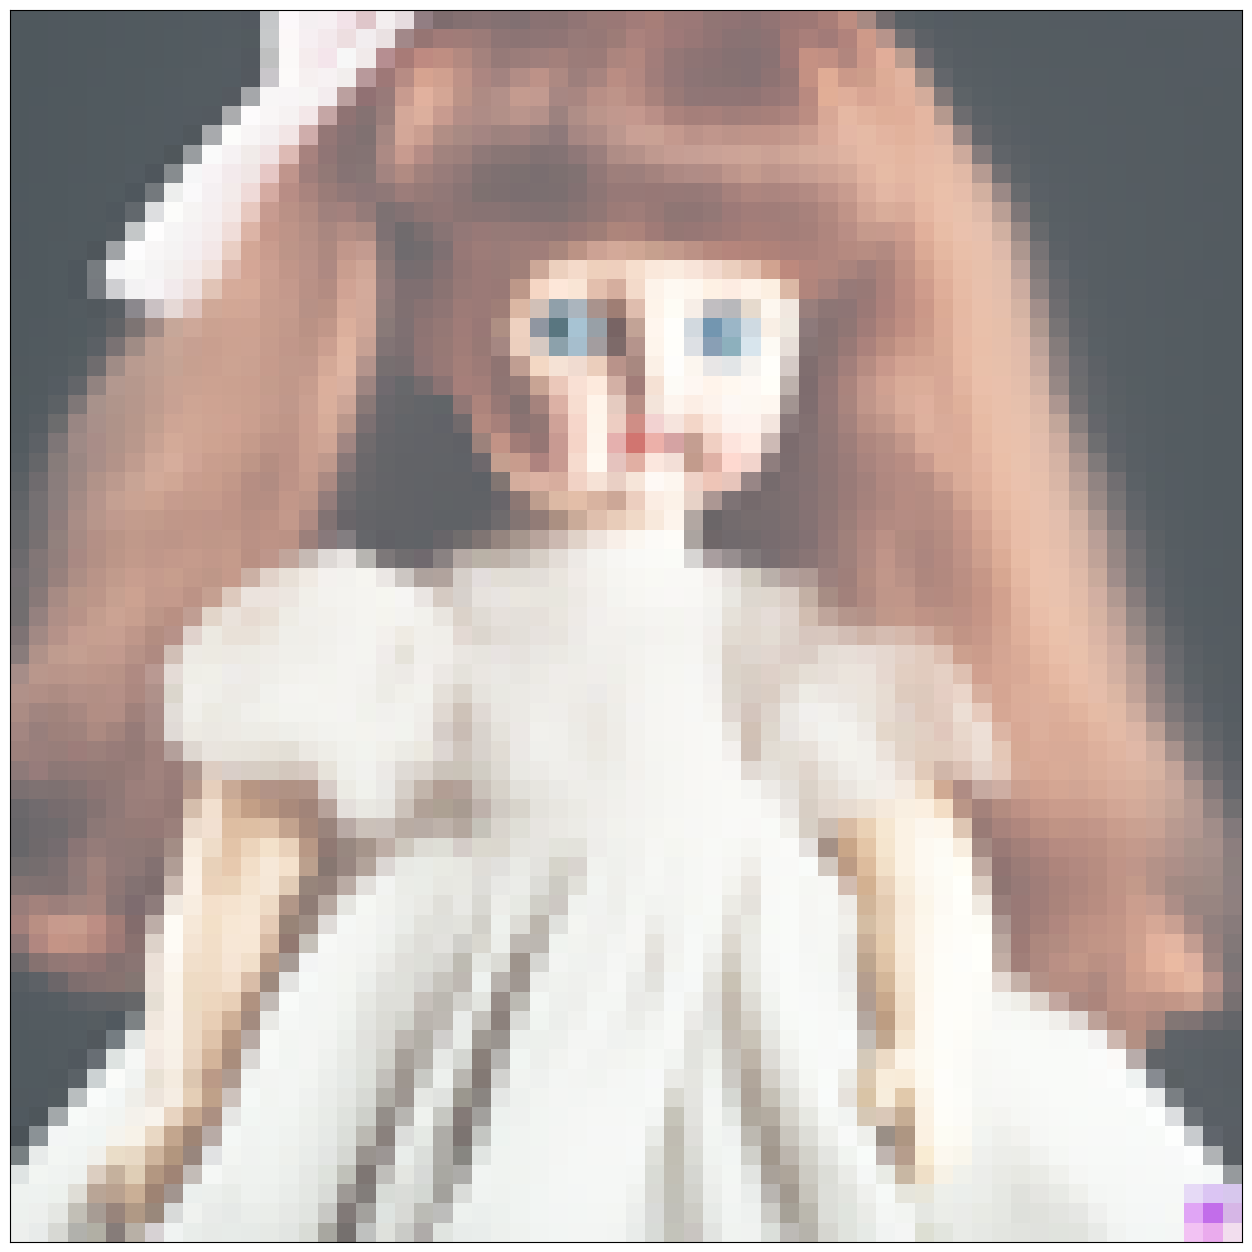

In [8]:
basic_test(t5, if_I, None, "a doll")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.04it/s]


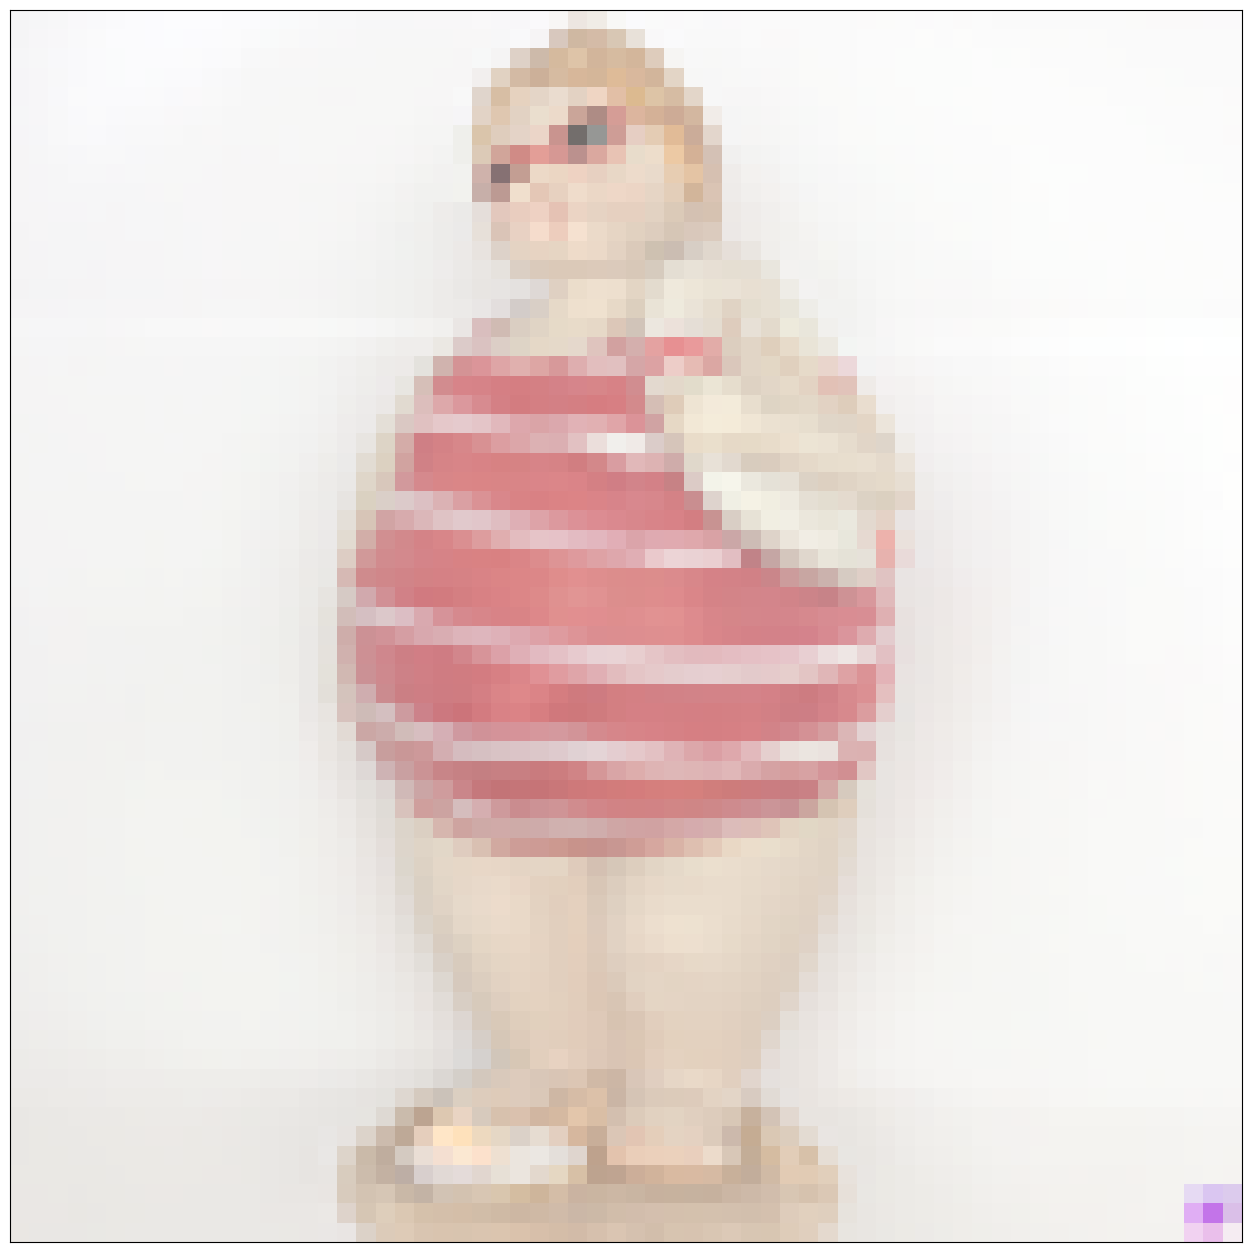

In [9]:
basic_test(t5, if_I, None, "a photo of a [V*] doll, white background")

In [10]:
if_II = IFStageII('IF-II-L-v1.0', device=DEVICE, model_kwargs={"precision": 32})
if_II.model.to(dtype=if_II.model.dtype)

SuperResUNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=160, out_features=1280, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(6, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 160, eps=1e-05, affine=True)
          (1): GELU(approximate='none')
          (2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): Identity()
          (1): Linear(in_features=1280, out_features=320, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 160, eps=1e-05, affine=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, i

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.12it/s]


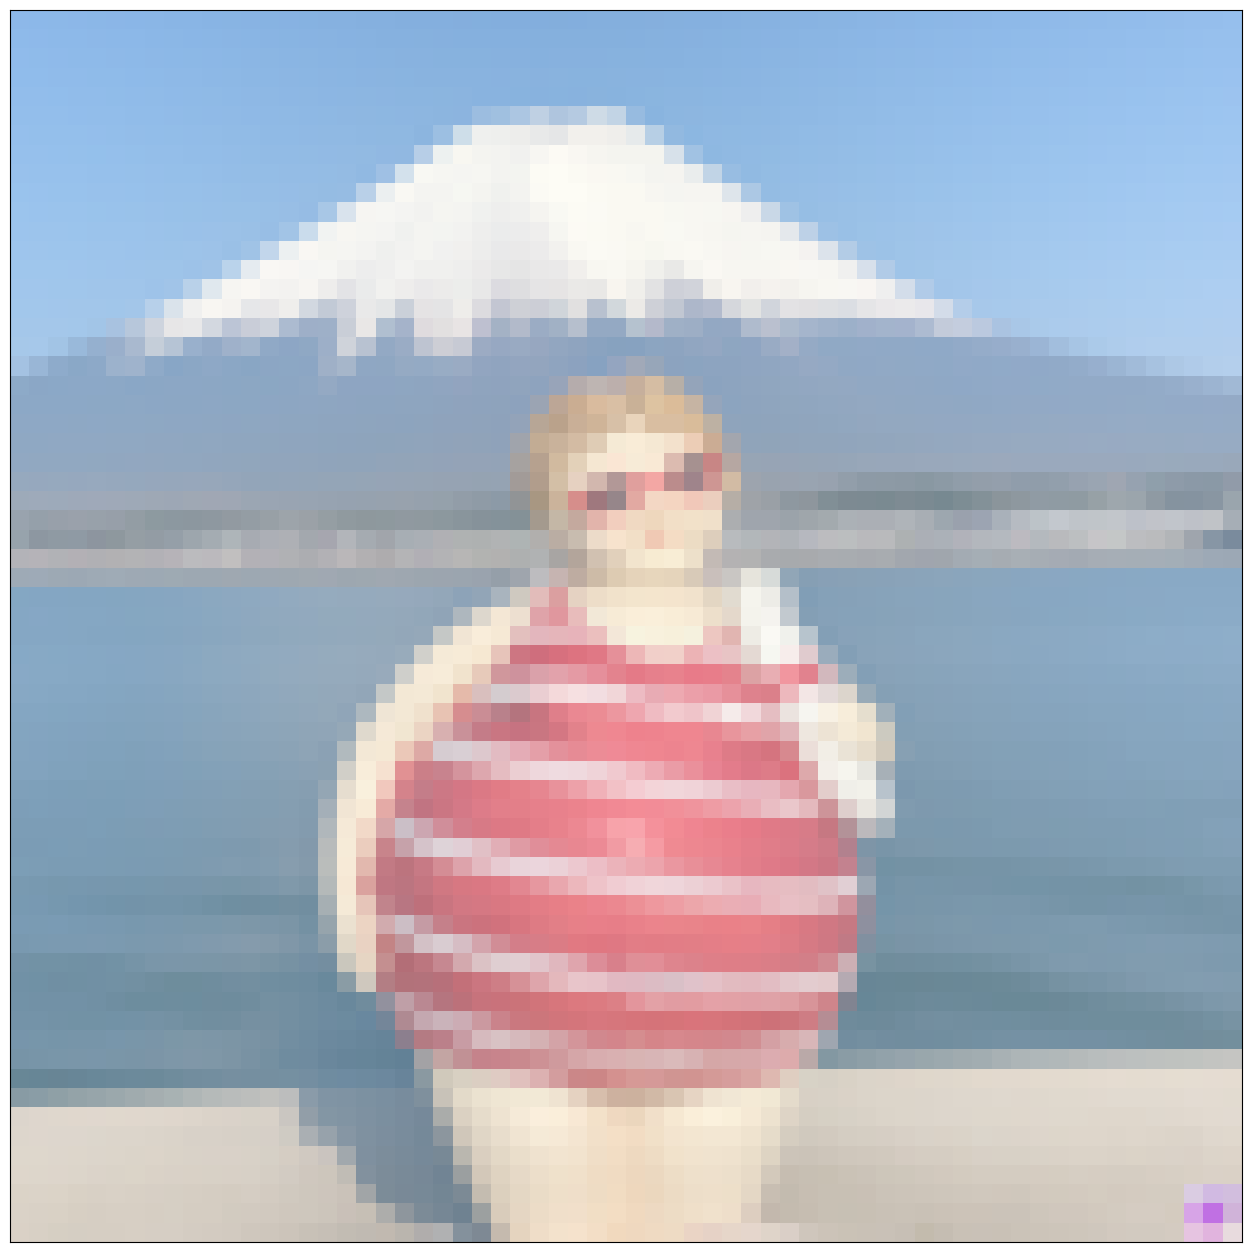

In [17]:
basic_test(t5, if_I, None, "a [V*] doll in front of mountain Fuji")